# hello

In [1]:
print("hello")

hello


In [2]:
import pandas as pd

# Path to dataset folder
DATA_PATH = "e_commerce_HW3_dataset/"

# Load datasets
aisles = pd.read_csv(DATA_PATH + "aisles.csv")
departments = pd.read_csv(DATA_PATH + "departments.csv")
products = pd.read_csv(DATA_PATH + "products.csv")
orders = pd.read_csv(DATA_PATH + "orders.csv")
order_products_prior = pd.read_csv(DATA_PATH + "order_products__prior.csv")
order_products_train = pd.read_csv(DATA_PATH + "order_products__train.csv")

# Quick check
print("Datasets loaded successfully:")
print(f"aisles: {aisles.shape}")
print(f"departments: {departments.shape}")
print(f"products: {products.shape}")
print(f"orders: {orders.shape}")
print(f"order_products_prior: {order_products_prior.shape}")
print(f"order_products_train: {order_products_train.shape}")


Datasets loaded successfully:
aisles: (134, 2)
departments: (21, 2)
products: (49688, 4)
orders: (3421083, 7)
order_products_prior: (32434489, 4)
order_products_train: (1384617, 4)


In [3]:
orders = orders.drop(columns=['days_since_prior_order'])


In [4]:
order_sizes = order_products_prior.groupby('order_id').size()
valid_orders = order_sizes[order_sizes >= 2].index

order_products_prior = order_products_prior[
    order_products_prior['order_id'].isin(valid_orders)
]


In [5]:
order_products_prior = order_products_prior.merge(
    products[['product_id', 'product_name']],
    on='product_id',
    how='left'
)


In [6]:
sample_orders = order_products_prior['order_id'].drop_duplicates().sample(20000, random_state=42)

order_products_sample = order_products_prior[
    order_products_prior['order_id'].isin(sample_orders)
]


In [7]:
order_products_sample

,order_id,product_id,add_to_cart_order,reordered,product_name
784,91,5825,1,1,Organic Celery
785,91,44303,2,1,Organic Shredded Unsweetened Coconut
786,91,48784,3,1,Lightly Breaded Fish Sticks
787,91,23293,4,1,Quinoa & Leeks with Chicken + Tarragon Organic...
788,91,42813,5,1,Smoked Maple Ham
...,...,...,...,...,...
32276174,3420917,49683,21,1,Cucumber Kirby
32276175,3420917,27458,22,1,Panko Japanese Style Bread Crumbs
32277304,3421032,1685,1,1,Clean Care 1-Ply Double Rolls Toilet Paper
32277305,3421032,3007,2,0,Natural Anticavity Silly Strawberry Fluoride T...


# Task II

In [8]:
# Group products by order_id to create baskets
baskets = (
    order_products_sample
    .groupby('order_id')['product_name']
    .apply(list)
)

print("Number of baskets:", baskets.shape[0])
print("Example basket:", baskets.iloc[0])


Number of baskets: 20000
Example basket: ['Organic Celery', 'Organic Shredded Unsweetened Coconut', 'Lightly Breaded Fish Sticks', 'Quinoa & Leeks with Chicken + Tarragon Organic Baby Food', 'Smoked Maple Ham', 'Organic Avocados']


In [9]:
# Convert baskets to list of lists (transactions)
transactions = baskets.tolist()


In [10]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)

basket_df = pd.DataFrame(
    te_array,
    columns=te.columns_
)

basket_df.head()


,#2 Coffee Filters,#4 Natural Brown Coffee Filters,& Go! Hazelnut Spread + Pretzel Sticks,+Energy Black Cherry Vegetable & Fruit Juice,0 Calorie Fuji Apple Pear Water Beverage,0 Calorie Strawberry Dragonfruit Water Beverage,0% Fat Black Cherry Greek Yogurt y,0% Fat Blueberry Greek Yogurt,0% Fat Free Organic Milk,0% Fat Greek Yogurt Black Cherry on the Bottom,...,smartwater® Electrolyte Enhanced Water,vitaminwater® XXX Acai Blueberry Pomegranate,with Crispy Almonds Cereal,with Dawn Action Pacs Fresh Scent Dishwasher Detergent Pacs,with Olive Oil Mayonnaise,with Olive Oil Mayonnaise Dressing,with Xylitol Cinnamon 18 Sticks Sugar Free Gum,with Xylitol Island Berry Lime 18 Sticks Sugar Free Gum,with a Splash of Mango Coconut Water,with a Splash of Pineapple Coconut Water
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [11]:
print("Number of transactions:", basket_df.shape[0])
print("Number of unique products:", basket_df.shape[1])


Number of transactions: 20000
Number of unique products: 21948


# Task III

In [13]:
import pandas as pd
from mlxtend.frequent_patterns import apriori

# --- (Recommended) convert True/False to 0/1 to reduce memory and avoid warnings ---
basket_bin = basket_df.astype("uint8")

def run_apriori_and_summarize(data, min_support: float):
    """
    Runs Apriori and returns:
    - frequent_itemsets dataframe
    - summary dictionary (count + max length + avg length)
    """
    frequent_itemsets = apriori(
        data,
        min_support=min_support,
        use_colnames=True,
        max_len=None,      # can set e.g. max_len=3 if runtime is too high
        low_memory=True
    )

    # Add itemset length for analysis
    frequent_itemsets["itemset_size"] = frequent_itemsets["itemsets"].apply(len)

    summary = {
        "min_support": min_support,
        "num_itemsets": int(frequent_itemsets.shape[0]),
        "max_itemset_size": int(frequent_itemsets["itemset_size"].max()) if not frequent_itemsets.empty else 0,
        "avg_itemset_size": float(frequent_itemsets["itemset_size"].mean()) if not frequent_itemsets.empty else 0.0
    }
    return frequent_itemsets, summary

# --- Run Apriori for two support thresholds ---
freq_001, summary_001 = run_apriori_and_summarize(basket_bin, min_support=0.01)
freq_005, summary_005 = run_apriori_and_summarize(basket_bin, min_support=0.05)

# --- Compare results ---
comparison = pd.DataFrame([summary_001, summary_005])
print(comparison)

# --- (Optional) Top 15 most frequent itemsets for each support ---
print("\nTop itemsets (min_support=0.01):")
display(freq_001.sort_values("support", ascending=False).head(15))

print("\nTop itemsets (min_support=0.05):")
display(freq_005.sort_values("support", ascending=False).head(15))


D:\CSE\cse terms\term 9 - cse7\EC\EC-HW3\.venv\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:175: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
D:\CSE\cse terms\term 9 - cse7\EC\EC-HW3\.venv\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:175: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


   min_support  num_itemsets  max_itemset_size  avg_itemset_size
0         0.01           128                 2          1.140625
1         0.05             7                 1          1.000000

Top itemsets (min_support=0.01):


,support,itemsets,itemset_size
6,0.15665,(Banana),1
5,0.12735,(Bag of Organic Bananas),1
79,0.08550,(Organic Strawberries),1
40,0.07675,(Organic Baby Spinach),1
60,0.06850,(Organic Hass Avocado),1
36,0.05750,(Organic Avocado),1
31,0.05270,(Large Lemon),1
102,0.04695,(Strawberries),1
68,0.04560,(Organic Raspberries),1
33,0.04455,(Limes),1



Top itemsets (min_support=0.05):


,support,itemsets,itemset_size
1,0.15665,(Banana),1
0,0.12735,(Bag of Organic Bananas),1
6,0.08550,(Organic Strawberries),1
4,0.07675,(Organic Baby Spinach),1
5,0.06850,(Organic Hass Avocado),1
3,0.05750,(Organic Avocado),1
2,0.05270,(Large Lemon),1


## Task 3 – Conceptual Questions

in the it own md file and doc

# Task 4

In [14]:
from mlxtend.frequent_patterns import association_rules
import pandas as pd

# Use frequent itemsets from min_support=0.01 (recommended)
# freq_001 should have columns: support, itemsets, itemset_size

rules = association_rules(
    freq_001,
    metric="lift",
    min_threshold=1.0
)

print("Rules shape:", rules.shape)
rules.head()


Rules shape: (34, 14)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Organic Baby Spinach),(Bag of Organic Bananas),0.07675,0.12735,0.01575,0.205212,1.611400,1.0,0.005976,1.097965,0.410963,0.083621,0.089224,0.164443
1,(Bag of Organic Bananas),(Organic Baby Spinach),0.12735,0.07675,0.01575,0.123675,1.611400,1.0,0.005976,1.053547,0.434792,0.083621,0.050826,0.164443
2,(Organic Hass Avocado),(Bag of Organic Bananas),0.06850,0.12735,0.02140,0.312409,2.453151,1.0,0.012677,1.269141,0.635922,0.122671,0.212065,0.240225
3,(Bag of Organic Bananas),(Organic Hass Avocado),0.12735,0.06850,0.02140,0.168041,2.453151,1.0,0.012677,1.119646,0.678807,0.122671,0.106861,0.240225
4,(Bag of Organic Bananas),(Organic Raspberries),0.12735,0.04560,0.01385,0.108755,2.384987,1.0,0.008043,1.070862,0.665456,0.087052,0.066173,0.206242


In [15]:
# Add rule sizes (helpful for analysis)
rules["antecedent_size"] = rules["antecedents"].apply(len)
rules["consequent_size"] = rules["consequents"].apply(len)

# Optional: keep only 1-item -> 1-item rules (cleanest for interpretation)
rules_1to1 = rules[(rules["antecedent_size"] == 1) & (rules["consequent_size"] == 1)].copy()

print("1-to-1 Rules shape:", rules_1to1.shape)


1-to-1 Rules shape: (34, 16)


In [16]:
def summarize_metric(df, col):
    return df[col].describe()[["min", "25%", "50%", "mean", "75%", "max"]]

summary_df = pd.DataFrame({
    "support": summarize_metric(rules_1to1, "support"),
    "confidence": summarize_metric(rules_1to1, "confidence"),
    "lift": summarize_metric(rules_1to1, "lift")
})

print(summary_df)


       support  confidence      lift
min   0.010400    0.067028  1.355127
25%   0.010550    0.117745  1.607711
50%   0.013600    0.152810  1.849153
mean  0.014088    0.178649  1.947474
75%   0.017050    0.233493  2.356607
max   0.021400    0.380560  2.949626


In [17]:
top3_lift = rules_1to1.sort_values("lift", ascending=False).head(3)

# Make it readable
top3_lift_display = top3_lift[[
    "antecedents", "consequents", "support", "confidence", "lift"
]].copy()

print("Top 3 rules by lift:")
display(top3_lift_display)


Top 3 rules by lift:


,antecedents,consequents,support,confidence,lift
33,(Organic Raspberries),(Organic Strawberries),0.0115,0.252193,2.949626
32,(Organic Strawberries),(Organic Raspberries),0.0115,0.134503,2.949626
2,(Organic Hass Avocado),(Bag of Organic Bananas),0.0214,0.312409,2.453151


In [18]:
top10_conf = rules_1to1.sort_values("confidence", ascending=False).head(10)
display(top10_conf[["antecedents", "consequents", "support", "confidence", "lift"]])


,antecedents,consequents,support,confidence,lift
16,(Organic Fuji Apple),(Banana),0.01155,0.380560,2.429366
2,(Organic Hass Avocado),(Bag of Organic Bananas),0.02140,0.312409,2.453151
13,(Organic Avocado),(Banana),0.01770,0.307826,1.965056
5,(Organic Raspberries),(Bag of Organic Bananas),0.01385,0.303728,2.384987
23,(Strawberries),(Banana),0.01360,0.289670,1.849153
9,(Large Lemon),(Banana),0.01430,0.271347,1.732188
33,(Organic Raspberries),(Organic Strawberries),0.01150,0.252193,2.949626
21,(Organic Whole Milk),(Banana),0.01055,0.240319,1.534114
10,(Limes),(Banana),0.01050,0.235690,1.504566
7,(Organic Strawberries),(Bag of Organic Bananas),0.01940,0.226901,1.781709


# Task 5

In [19]:
# 1) Build baskets (Task 2 already done)
# basket_df: one-hot encoded matrix (20000 x 21948)

# 2) Frequent itemsets (Task 3)
from mlxtend.frequent_patterns import apriori
freq_001 = apriori(basket_df.astype("uint8"), min_support=0.01, use_colnames=True, low_memory=True)
freq_001["itemset_size"] = freq_001["itemsets"].apply(len)

# 3) Association rules (Task 4)
from mlxtend.frequent_patterns import association_rules
rules = association_rules(freq_001, metric="lift", min_threshold=1.0)
rules["antecedent_size"] = rules["antecedents"].apply(len)
rules["consequent_size"] = rules["consequents"].apply(len)
rules_1to1 = rules[(rules["antecedent_size"]==1) & (rules["consequent_size"]==1)].copy()

print("Frequent itemsets:", freq_001.shape)
print("Rules (1-to-1):", rules_1to1.shape)


D:\CSE\cse terms\term 9 - cse7\EC\EC-HW3\.venv\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:175: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Frequent itemsets: (128, 3)
Rules (1-to-1): (34, 16)


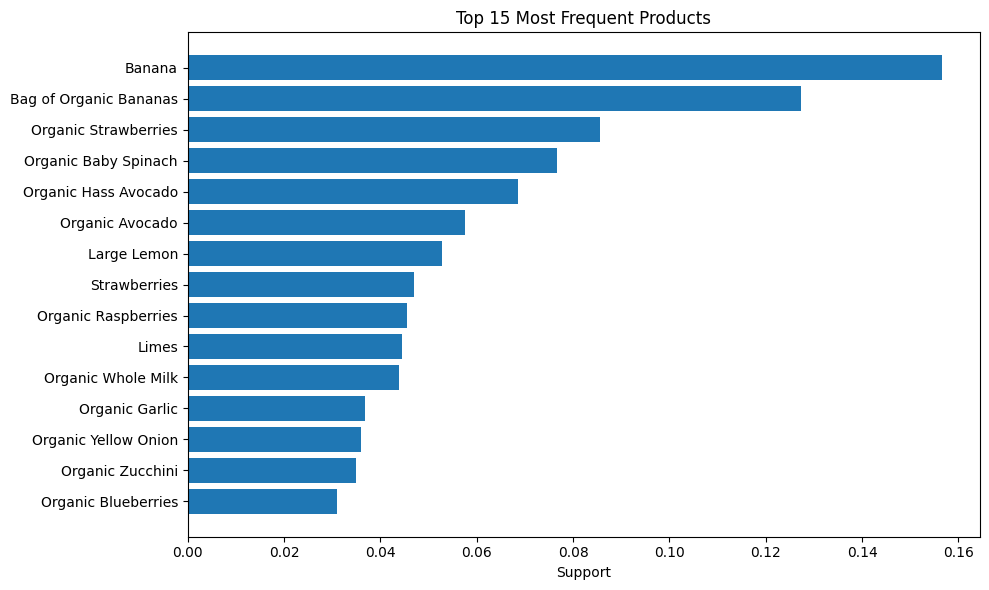

In [20]:
import matplotlib.pyplot as plt

top_items = freq_001[freq_001["itemset_size"] == 1].copy()
top_items["product"] = top_items["itemsets"].apply(lambda x: list(x)[0])
top_items = top_items.sort_values("support", ascending=False).head(15)

plt.figure(figsize=(10, 6))
plt.barh(top_items["product"][::-1], top_items["support"][::-1])
plt.xlabel("Support")
plt.title("Top 15 Most Frequent Products")
plt.tight_layout()
plt.show()


In [21]:
freq_table = freq_001.sort_values(["itemset_size","support"], ascending=[True, False]).head(20)
freq_table


,support,itemsets,itemset_size
6,0.15665,(Banana),1
5,0.12735,(Bag of Organic Bananas),1
79,0.08550,(Organic Strawberries),1
40,0.07675,(Organic Baby Spinach),1
60,0.06850,(Organic Hass Avocado),1
36,0.05750,(Organic Avocado),1
31,0.05270,(Large Lemon),1
102,0.04695,(Strawberries),1
68,0.04560,(Organic Raspberries),1
33,0.04455,(Limes),1


In [23]:
rules_table = rules_1to1.sort_values("lift", ascending=False).head(20)
rules_table_display = rules_table[["antecedents","consequents","support","confidence","lift"]]
rules_table_display


,antecedents,consequents,support,confidence,lift
33,(Organic Raspberries),(Organic Strawberries),0.01150,0.252193,2.949626
32,(Organic Strawberries),(Organic Raspberries),0.01150,0.134503,2.949626
2,(Organic Hass Avocado),(Bag of Organic Bananas),0.02140,0.312409,2.453151
3,(Bag of Organic Bananas),(Organic Hass Avocado),0.02140,0.168041,2.453151
17,(Banana),(Organic Fuji Apple),0.01155,0.073731,2.429366
16,(Organic Fuji Apple),(Banana),0.01155,0.380560,2.429366
4,(Bag of Organic Bananas),(Organic Raspberries),0.01385,0.108755,2.384987
5,(Organic Raspberries),(Bag of Organic Bananas),0.01385,0.303728,2.384987
25,(Organic Avocado),(Organic Baby Spinach),0.01040,0.180870,2.356607
24,(Organic Baby Spinach),(Organic Avocado),0.01040,0.135505,2.356607


# extra plots

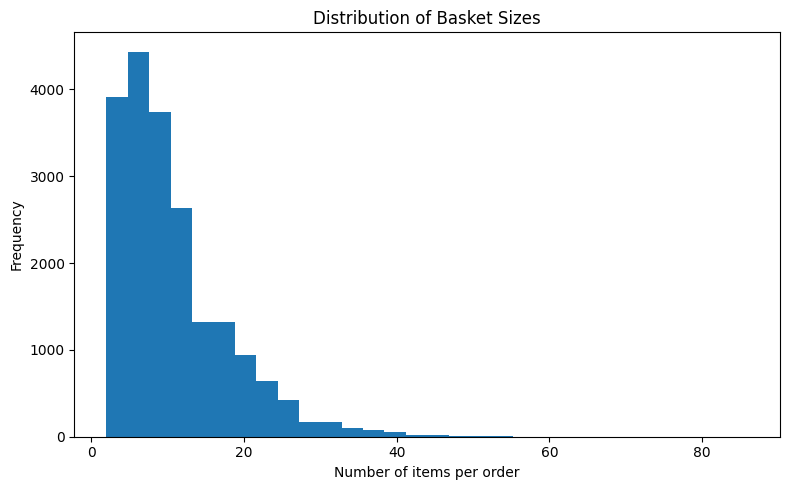

In [24]:
import matplotlib.pyplot as plt

basket_sizes = baskets.apply(len)

plt.figure(figsize=(8,5))
plt.hist(basket_sizes, bins=30)
plt.xlabel("Number of items per order")
plt.ylabel("Frequency")
plt.title("Distribution of Basket Sizes")
plt.tight_layout()
plt.show()


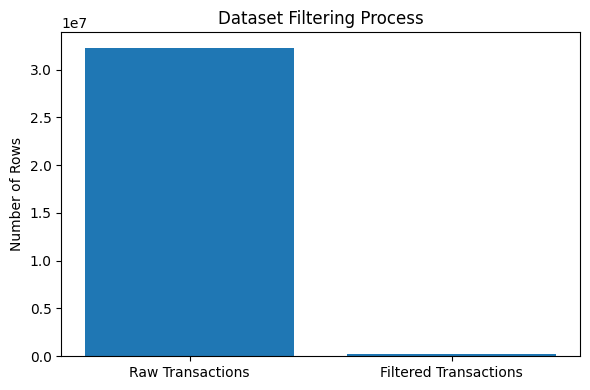

In [25]:
raw_orders = order_products_prior.shape[0]
filtered_orders = order_products_sample.shape[0]

plt.figure(figsize=(6,4))
plt.bar(["Raw Transactions", "Filtered Transactions"],
        [raw_orders, filtered_orders])
plt.ylabel("Number of Rows")
plt.title("Dataset Filtering Process")
plt.tight_layout()
plt.show()


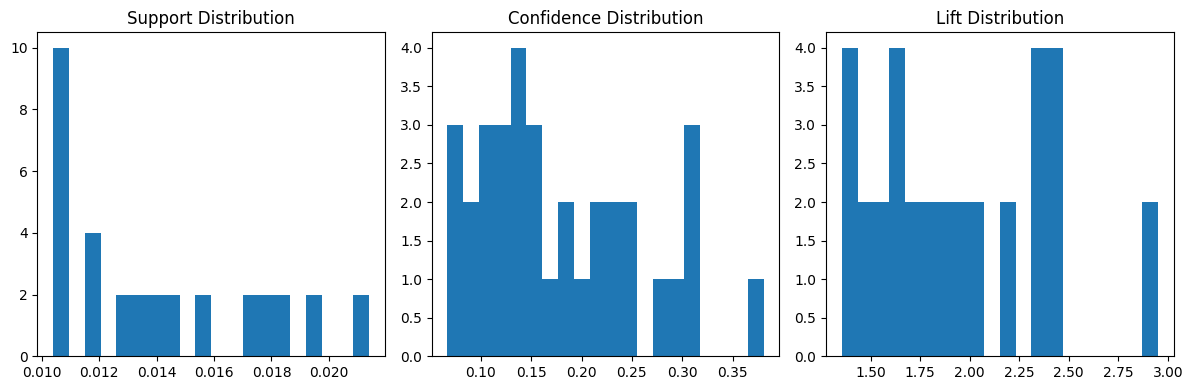

In [26]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.hist(rules_1to1["support"], bins=20)
plt.title("Support Distribution")

plt.subplot(1,3,2)
plt.hist(rules_1to1["confidence"], bins=20)
plt.title("Confidence Distribution")

plt.subplot(1,3,3)
plt.hist(rules_1to1["lift"], bins=20)
plt.title("Lift Distribution")

plt.tight_layout()
plt.show()


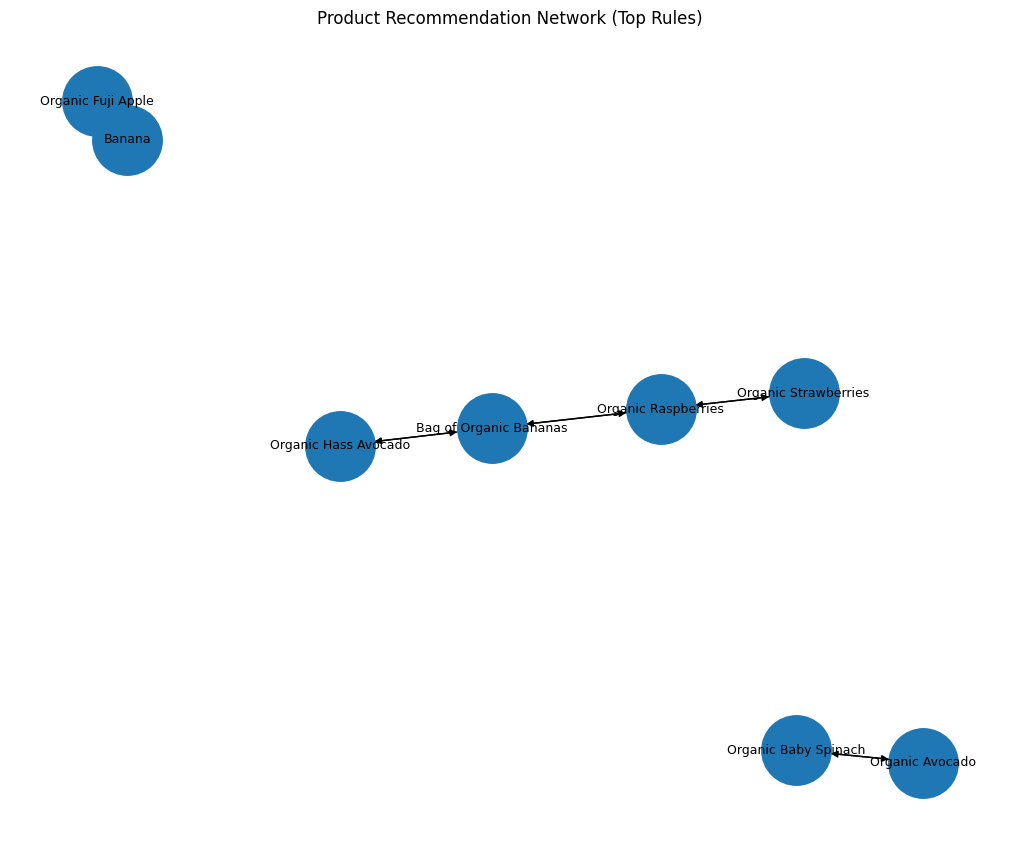

In [28]:
import networkx as nx

top_rules = rules_1to1.sort_values("lift", ascending=False).head(10)

G = nx.DiGraph()

for _, row in top_rules.iterrows():
    a = list(row["antecedents"])[0]
    b = list(row["consequents"])[0]
    G.add_edge(a, b, weight=row["lift"])

plt.figure(figsize=(10,8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=2500, font_size=9)
plt.title("Product Recommendation Network (Top Rules)")
plt.show()
